In [1]:
import gzip
import random
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import balanced_accuracy_score
from nltk.stem.porter import *

def readJSON(path):
    for l in gzip.open(path, 'r+'):
        d = eval(l)
        u = d['userID']
        try:
            g = d['gameID']
        except Exception as e:
            g = None
        yield u,g,d

In [2]:
train_num = 165000 #165000
bag_words_size = 500 #1000

data = [d for (u,g,d) in readJSON("train_Category.json.gz")]
data_train = data[:train_num]
data_valid = data[165000:]

In [3]:
len(data_valid)

10000

In [4]:
print("Prcessing data:")

wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in data_train:
    r = ''.join([c for c in d['text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:bag_words_size]]

print("10 most common words:")
for w in words[:10]:
    print("{} : {}".format(w, wordCount[w]))

Prcessing data:
10 most common words:
the : 544606
and : 317631
a : 305416
to : 291920
game : 285193
it : 274597
of : 227236
is : 208417
you : 200642
i : 195958


In [5]:
genreWords = [[], [], [] ,[] ,[]]
for d in data_train:
    genreWords[d['genreID']].append(d['text'].lower())
for i in range(len(genreWords)):
    for j in range(len(genreWords[i])):
        genreWords[i][j] = str(genreWords[i][j]).replace('\n', "")
        genreWords[i][j] = str(genreWords[i][j]).replace("'", "")
        genreWords[i][j] = str(genreWords[i][j]).replace(",", "")
        genreWords[i][j] = str(genreWords[i][j]).replace("͡°", "")
for c in string.punctuation:
    for i in range(len(genreWords)):
        for j in range(len(genreWords[i])):
            genreWords[i][j] = str(genreWords[i][j]).replace(c, "")
corpus = [str(genreWords[i]) for i in range(len(genreWords))]

In [6]:
# import stop words and tokenizer
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
# create vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=10000,
                        tokenizer=word_tokenize,
                        stop_words=stop_words)

# calculate TF-IDF
cogs_tfidf = pd.DataFrame(tfidf.fit_transform(corpus).toarray())
cogs_tfidf.columns = tfidf.get_feature_names()
cogs_tfidf = cogs_tfidf.rename(index={0:'Action', 1:'Strategy',2:'RPG', 3:'Adventure', 4:'Sport'})

most_unique = cogs_tfidf.idxmax(axis=1) 
most_unique

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Action            waka
Strategy      mrboness
RPG             ffxiii
Adventure      deponia
Sport        autosport
dtype: object

In [7]:
tfidf_words_set = set()
tfidf_words_set.update(cogs_tfidf.sort_values(by='Action', axis=1, ascending=False).columns[:400])
tfidf_words_set.update(cogs_tfidf.sort_values(by='Strategy', axis=1, ascending=False).columns[:400])
tfidf_words_set.update(cogs_tfidf.sort_values(by='RPG', axis=1, ascending=False).columns[:400])
tfidf_words_set.update(cogs_tfidf.sort_values(by='Adventure', axis=1, ascending=False).columns[:400])
tfidf_words_set.update(cogs_tfidf.sort_values(by='Sport', axis=1, ascending=False).columns[:400])
len(tfidf_words_set)
words = set(words) | tfidf_words_set

In [8]:
len(tfidf_words_set)

1013

In [9]:
print("Bag-of-words feature vectors:")

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)
tfidf_words_set 

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

def find_accuracy(pred, y):
    correct = np.array(pred) == np.array(y)
    return sum(correct) / len(correct)

#catDict = {}
#for d in data_train:
#    cat = d['genre']
#    if cat not in catDict:
#        catDict[cat] = len(catDict)
catDict = {
  "Action": 0,
  "Strategy": 1,
  "RPG": 2,
  "Adventure": 3,
  "Sport": 4
}

# Train on train set
X_train = [feature(d) for d in data_train]
y_train = [catDict[d['genre']] if d['genre'] in catDict else 0 for d in data_train]


#mod = linear_model.LogisticRegression(max_iter = 10000)
#mod.fit(X_train, y_train)

# Validate on validate set
#X_valid = [feature(d) for d in data_valid]
#y_valid = [catDict[d['genre']] if d['genre'] in catDict else 0 for d in data_valid]
#pred = mod.predict(X_valid)

#print("Accuracy: {}".format(find_accuracy(pred, y_valid)))
#print("BER: {}".format(balanced_accuracy_score(y_valid, pred)))

Bag-of-words feature vectors:


Improve upon the performance of the above classifier:
C = 1000 shows best results with accuracy = 0.6444, and BER = 0.5157004936325214


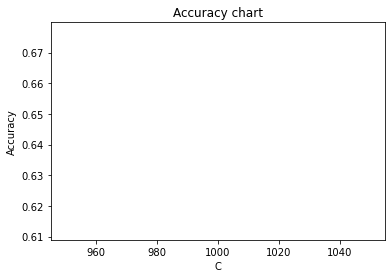

In [10]:
from sklearn.neural_network import MLPClassifier
print("Improve upon the performance of the above classifier:")
C_values = [1000]
accs = []
bers = []
for c in C_values:
    #mod = linear_model.LogisticRegression(C=c, max_iter = 10000)
    mod = MLPClassifier(hidden_layer_sizes=(100,), max_iter = 10000, max_fun = 420)
    mod.fit(X_train, y_train)
    
    X_valid = [feature(d) for d in data_valid]
    y_valid = [catDict[d['genre']] if d['genre'] in catDict else 0 for d in data_valid]
    pred = mod.predict(X_valid)
    
    accs.append(find_accuracy(pred, y_valid))
    bers.append(balanced_accuracy_score(y_valid, pred))
    
max_index = accs.index(max(accs))
best_c = C_values[max_index]
print("C = {} shows best results with accuracy = {}, and BER = {}".format(C_values[max_index], accs[max_index], bers[max_index]))

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy chart')
plt.plot(C_values, accs)
    

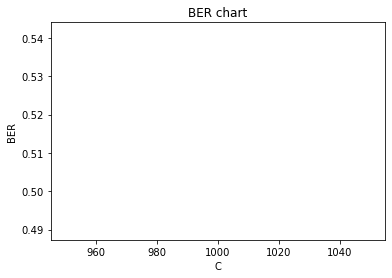

In [11]:
plt.xlabel('C')
plt.ylabel('BER')
plt.title('BER chart')
plt.plot(C_values, bers)

In [12]:
predictions = open("predictions_Category.txt", 'w')
predictions.write("userID-reviewID,prediction\n")
for u,_,d in readJSON("test_Category.json.gz"):
    X = [feature(d)]
    cat = mod.predict(X)
    predictions.write(u + '-' + d['reviewID'] + "," + str(cat[0]) + "\n")

predictions.close()